In [1]:
import glob
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values

In [3]:
train_history = load_multiple_metrics("toy1d_experiment0_protocol_test", "toy1d_train_history")

In [4]:
variations = ["Base", "SensorialMask", "CompleteProtocol"]
n_epoch = len(train_history[variations[0]]["means"]["optimizer_loss_train"])

color_map = {
    "Base":"#60BF60",
    "SensorialMasker":"#D36767",
    "CompleteProtocol":"#6060BF"
}

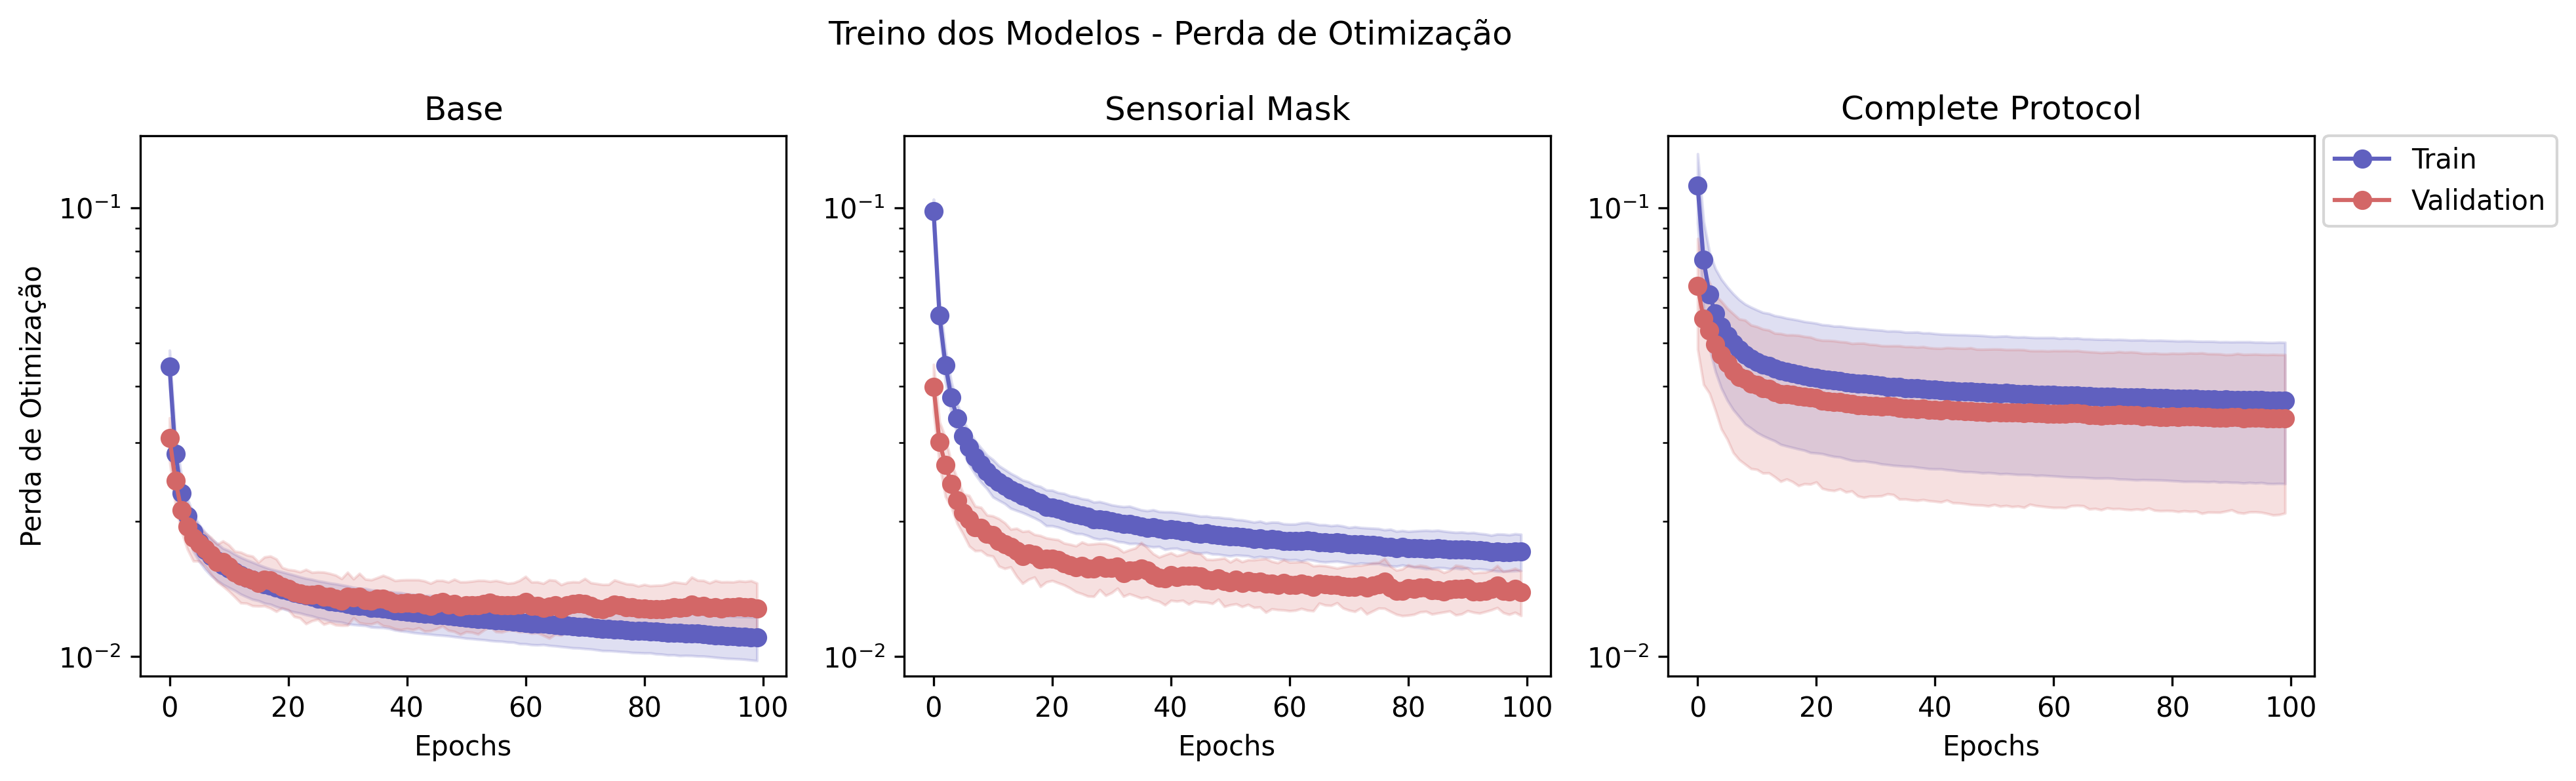

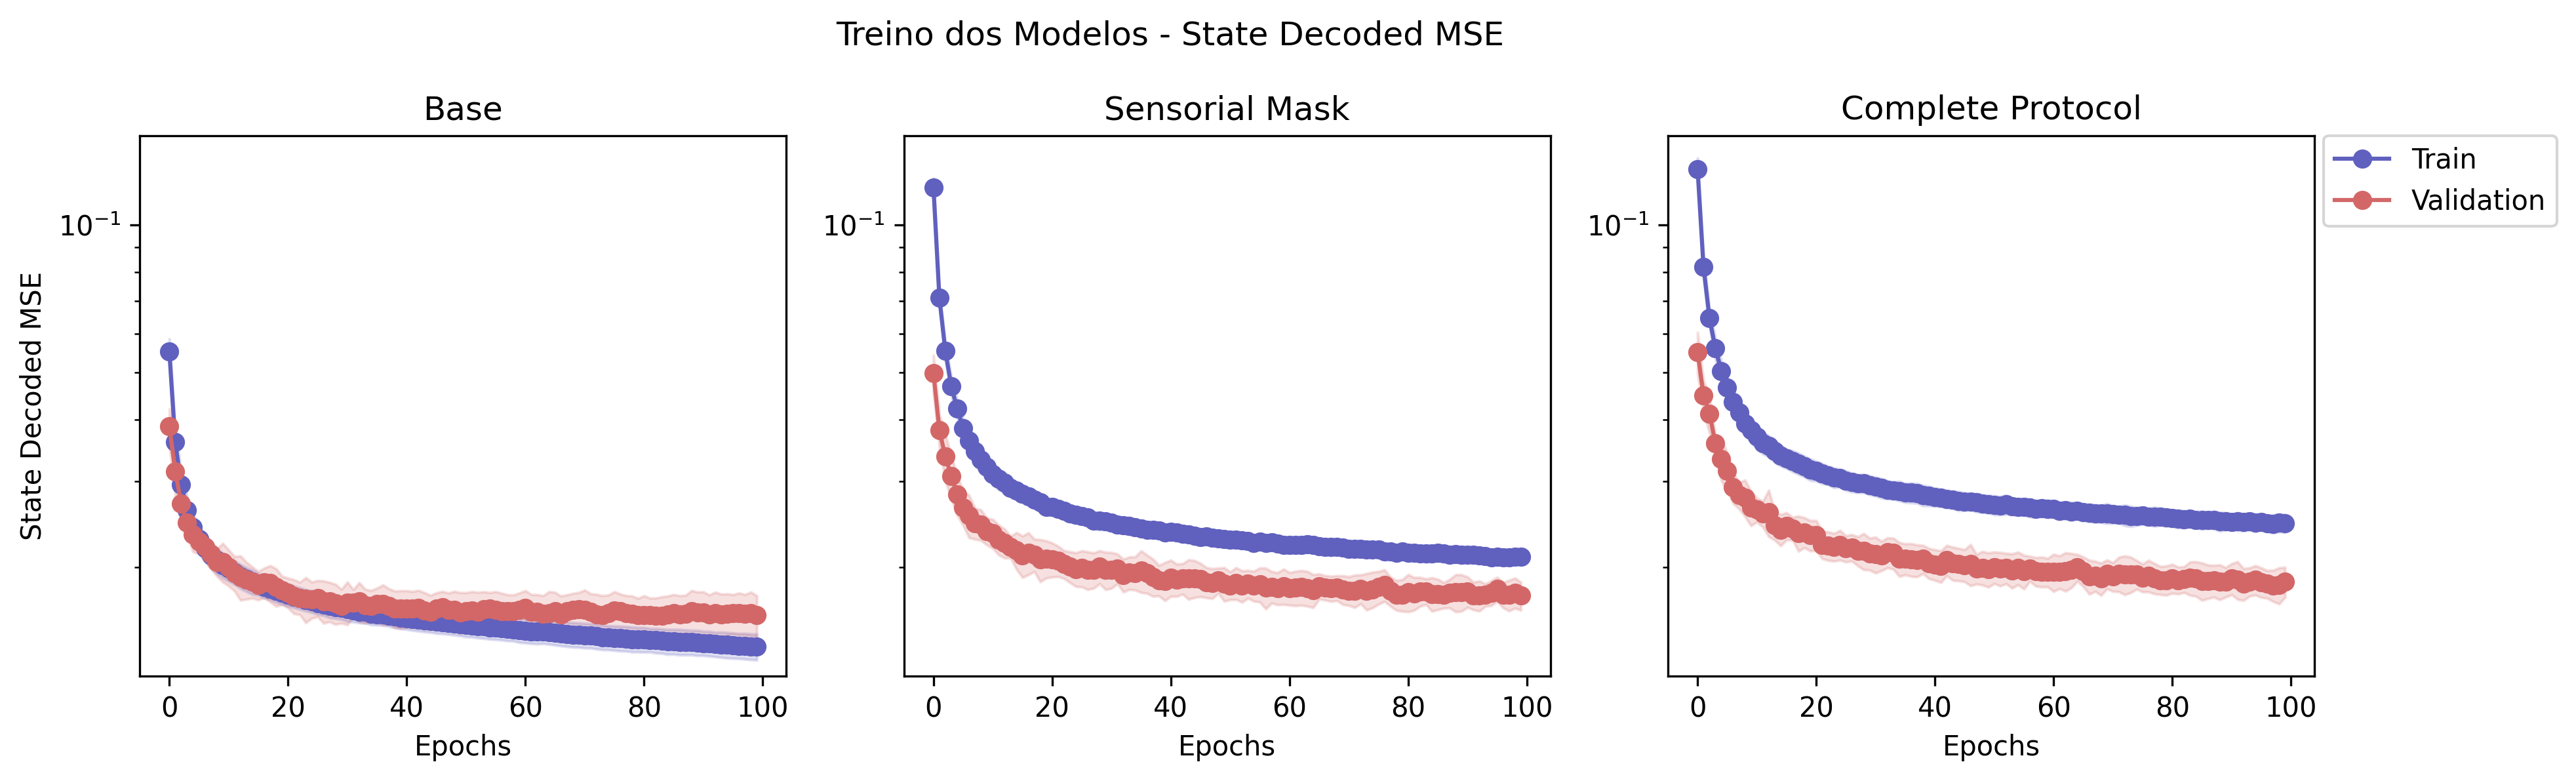

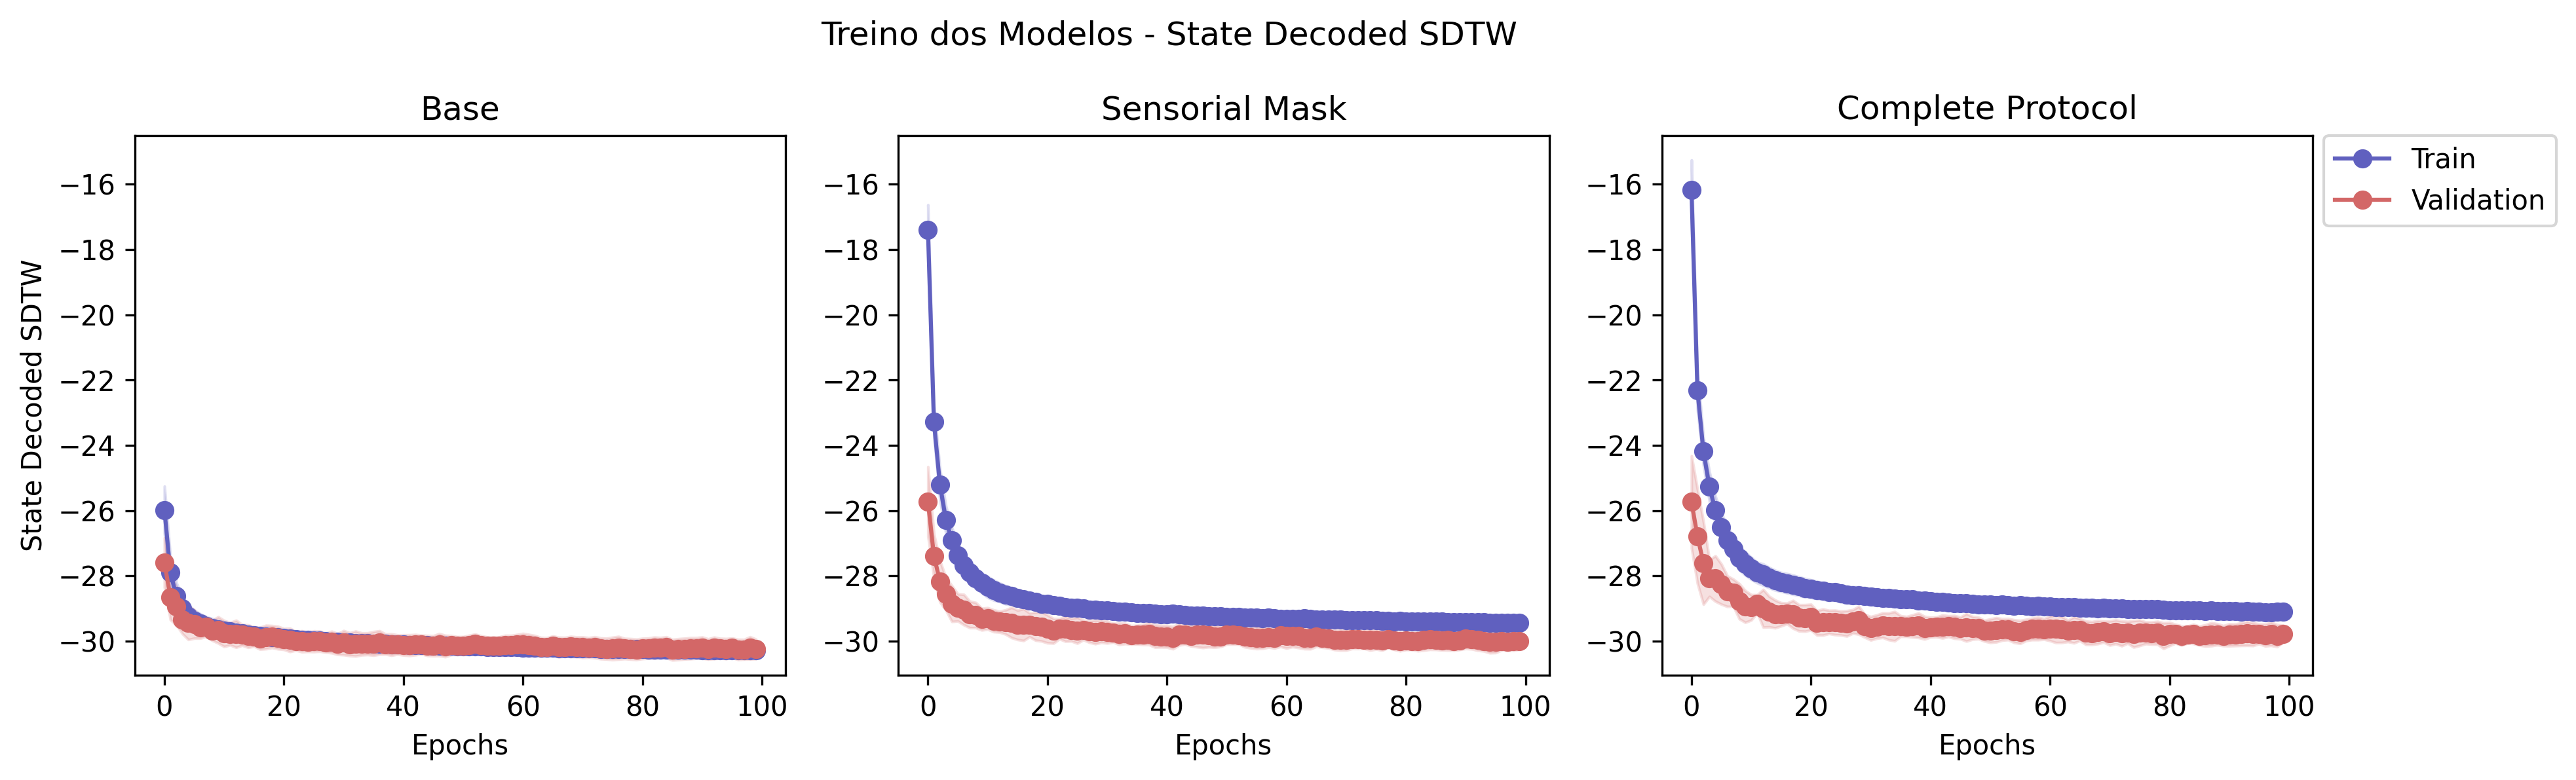

In [5]:
epochs = range(n_epoch)

figures = {}

from matplotlib.axes import Axes
from matplotlib.figure import Figure

metrics = ["optimizer_loss", "state_decoded_mse", "state_decoded_sdtw"]
ylabels = ["Perda de Otimização", "State Decoded MSE", "State Decoded SDTW"]

for i in range(len(metrics)):
    metric_name = metrics[i]
    ylabel = ylabels[i]
    plot_name = metric_name+"_train_history"

    fig, axs = plt.subplots(1, 3, dpi=300, figsize=(12,4))
    axs:list[Axes]

    for j, name in enumerate(variations):

        means = train_history[name]["means"][f"{metric_name}_train"]
        stds = train_history[name]["stds"][f"{metric_name}_train"]
        
        axs[j].plot(epochs, means, "o-", label="Train", color=color_map["CompleteProtocol"])
        axs[j].fill_between(epochs, means-stds, means+stds, color=color_map["CompleteProtocol"], alpha=.2)

        means = train_history[name]["means"][f"{metric_name}_val"]
        stds = train_history[name]["stds"][f"{metric_name}_val"]
        
        axs[j].plot(epochs, means, "o-", label="Validation", color=color_map["SensorialMasker"])
        axs[j].fill_between(epochs, means-stds, means+stds, color=color_map["SensorialMasker"], alpha=.2)

        #axs[j].errorbar(epochs, train_history[name]["means"]["optimizer_loss_train"], train_history[name]["stds"]["optimizer_loss_train"],  fmt="o-", label="Train", color=color_map["CompleteProtocol"])
        #axs[j].errorbar(epochs, train_history[name]["means"]["optimizer_loss_val"], train_history[name]["stds"]["optimizer_loss_val"],  fmt="o-", label="Validation", color=color_map["SensorialMasker"])

        axs[j].set_xlabel("Epochs")

        if j == 0:
            axs[j].set_ylabel(ylabel)

        if i != 2:
    
            axs[j].set_yscale("log")

        

        name = " ".join(re.sub( r"([A-Z])|(\d+)", r" \1\2", name).split())
        axs[j].set_title(name)


    maximum = -np.inf
    minimum = np.inf

    for ax in axs:
        maximum = max(maximum, ax.get_ylim()[1])
        minimum = min(minimum, ax.get_ylim()[0])

    for ax in axs:
        ax.set_ylim(minimum, maximum)

    plt.suptitle(f"Treino dos Modelos - {ylabel}")
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.375, 1), borderaxespad=0)

    figures[plot_name] = fig

    plt.show()

In [6]:
metrics = load_multiple_metrics("toy1d_experiment0_protocol_test", "toy1d_metrics")

In [7]:
mask_sensorial_metrics = load_multiple_metrics("toy1d_experiment0_protocol_test", "toy1d_mask_sensorial_metrics")

In [8]:
import copy

metrics_full = copy.deepcopy(metrics)

for var_name in metrics:
    metrics_full[var_name]["means"]["mask_sensorial_100"] = {}
    metrics_full[var_name]["stds"]["mask_sensorial_100"] = {}
    
    for loss_name in mask_sensorial_metrics[var_name]["means"]:
        if loss_name == "mask_sensorial_percentage":
            continue
        
        metrics_full[var_name]["means"]["mask_sensorial_100"][loss_name ]= mask_sensorial_metrics[var_name]["means"][loss_name][-1]
        metrics_full[var_name]["stds"]["mask_sensorial_100"][loss_name ]= mask_sensorial_metrics[var_name]["stds"][loss_name][-1]

In [9]:
pallete = list(color_map.values())

In [10]:
metrics_sorted = {}
name_map = {"Base":"Base", "SensorialMask": "Sensorial Mask", "CompleteProtocol":"Complete Protocol"}
for name in name_map:
    metrics_sorted[name_map[name]] = metrics_full[name]

In [11]:
import pandas as pd


def metrics_bar_with_errorbar(metrics:dict, metric_name:str, group_names:list[str], group_labels:list[str], entry_caption_title:str, pallete:list|None=None, errorbar_legend:str|None=None, ax=None):
    n_entry = len(metrics)
    entry_names = list(metrics.keys())

    df_metrics = []
    for i in range(n_entry):
        entry_name = entry_names[i]
        for j, group in enumerate(group_names):
            element = {}
            element["mean"] = get_values(metrics, ["means", group, metric_name])[i]
            element["std"] = get_values(metrics, ["stds", group, metric_name])[i]
            element["metric_name"] = group_labels[j]
            element[entry_caption_title] = entry_name
            
            df_metrics.append(element)
    df_metrics = pd.DataFrame(df_metrics)

    sns.barplot(df_metrics, x="metric_name", y="mean", hue=entry_caption_title, palette=pallete, ax=ax)


    width = 1/(3+0.75)

    entry_names = df_metrics[entry_caption_title].unique()

    for i, name in enumerate(group_labels):
        x_pos = i-(width*(len(entry_names)//2))
        for _, entry_name in enumerate(entry_names):
            entry = df_metrics[np.bitwise_and(df_metrics["metric_name"] == name, df_metrics[entry_caption_title] == entry_name)]

            ax.errorbar(x_pos, entry["mean"], entry["std"], color="black", ecolor="black", capsize=5, label=errorbar_legend)
            x_pos+=width

            errorbar_legend=None

    plt.xlabel("Metric")
    plt.legend()

In [12]:
metric_names = ["normal", "use_state", "prediction", "prediction_shallow", "mask_sensorial_100"]
metric_labels = ["Normal", "Use State", "Prediction", "Prediction Shallow", "Mask Sensorial@100%"]

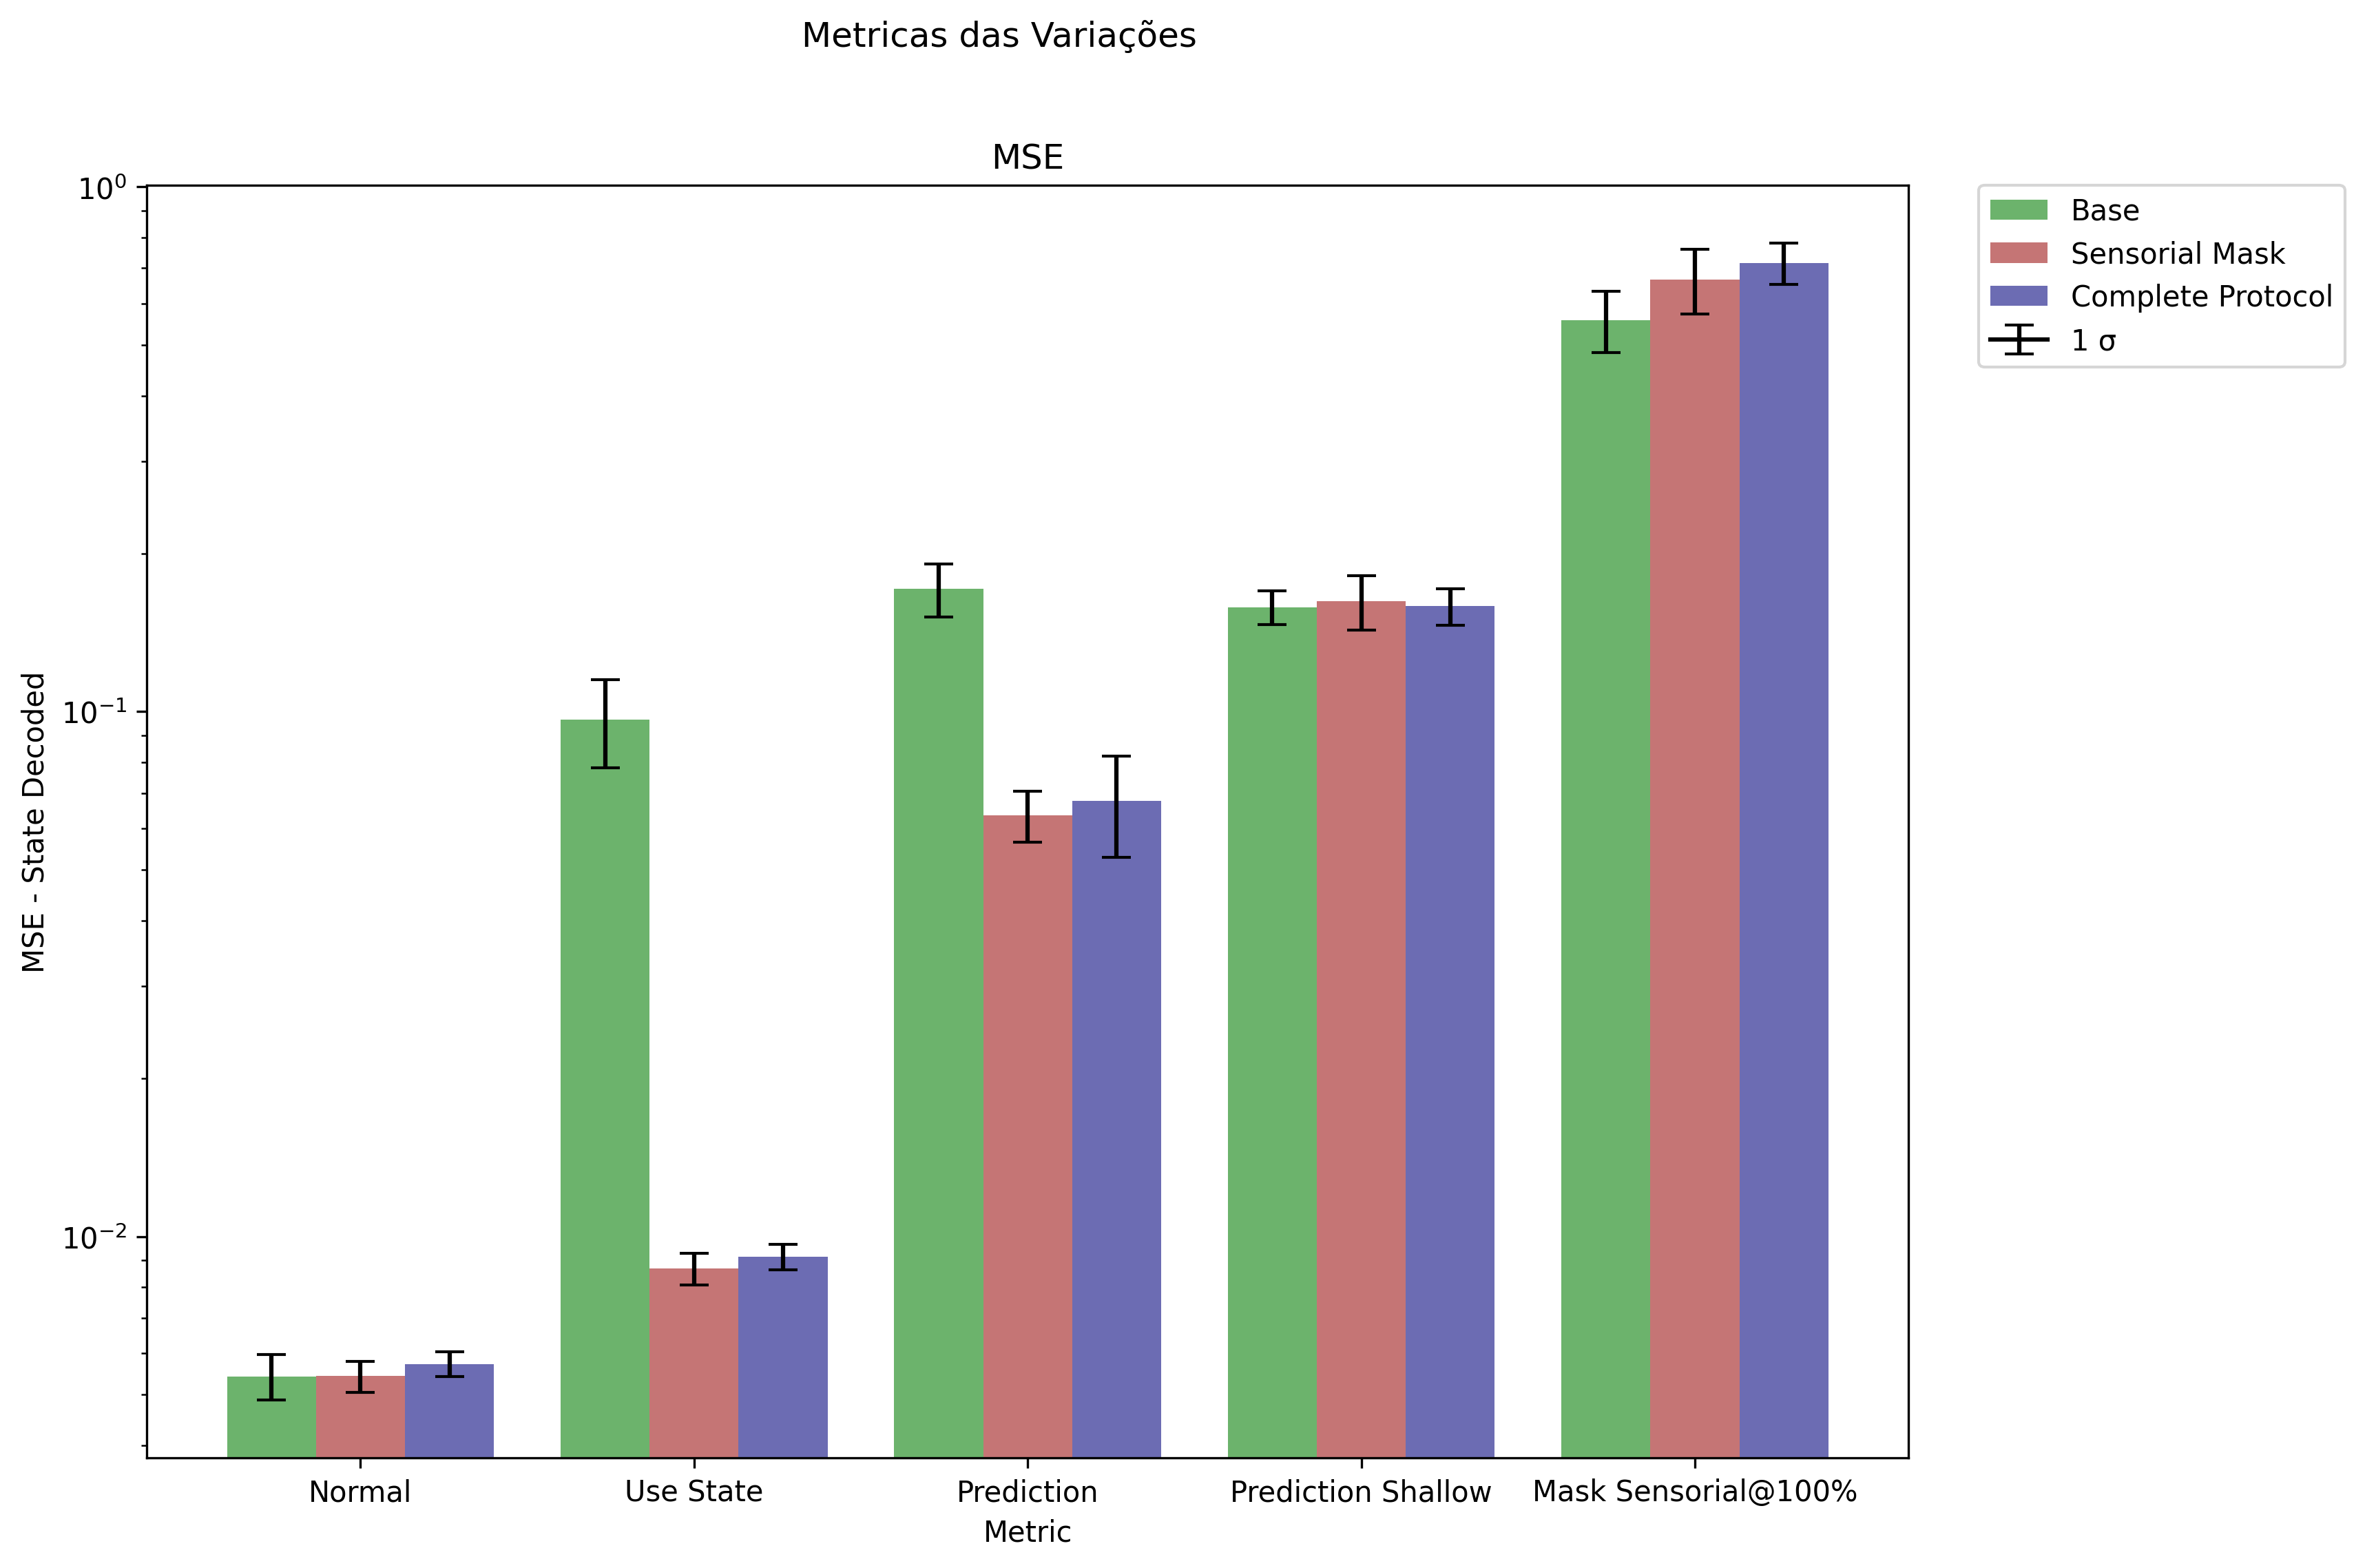

In [13]:
fig, ax = plt.subplots(dpi=300, figsize=(11, 8))

fig.suptitle("Metricas das Variações")
ax.set_title("MSE")

metrics_bar_with_errorbar(metrics_sorted, "state_decoded_mse", metric_names, metric_labels, "Variations", pallete, "1 σ", ax)
ax.set_ylabel("MSE - State Decoded")
ax.set_yscale("log")

ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

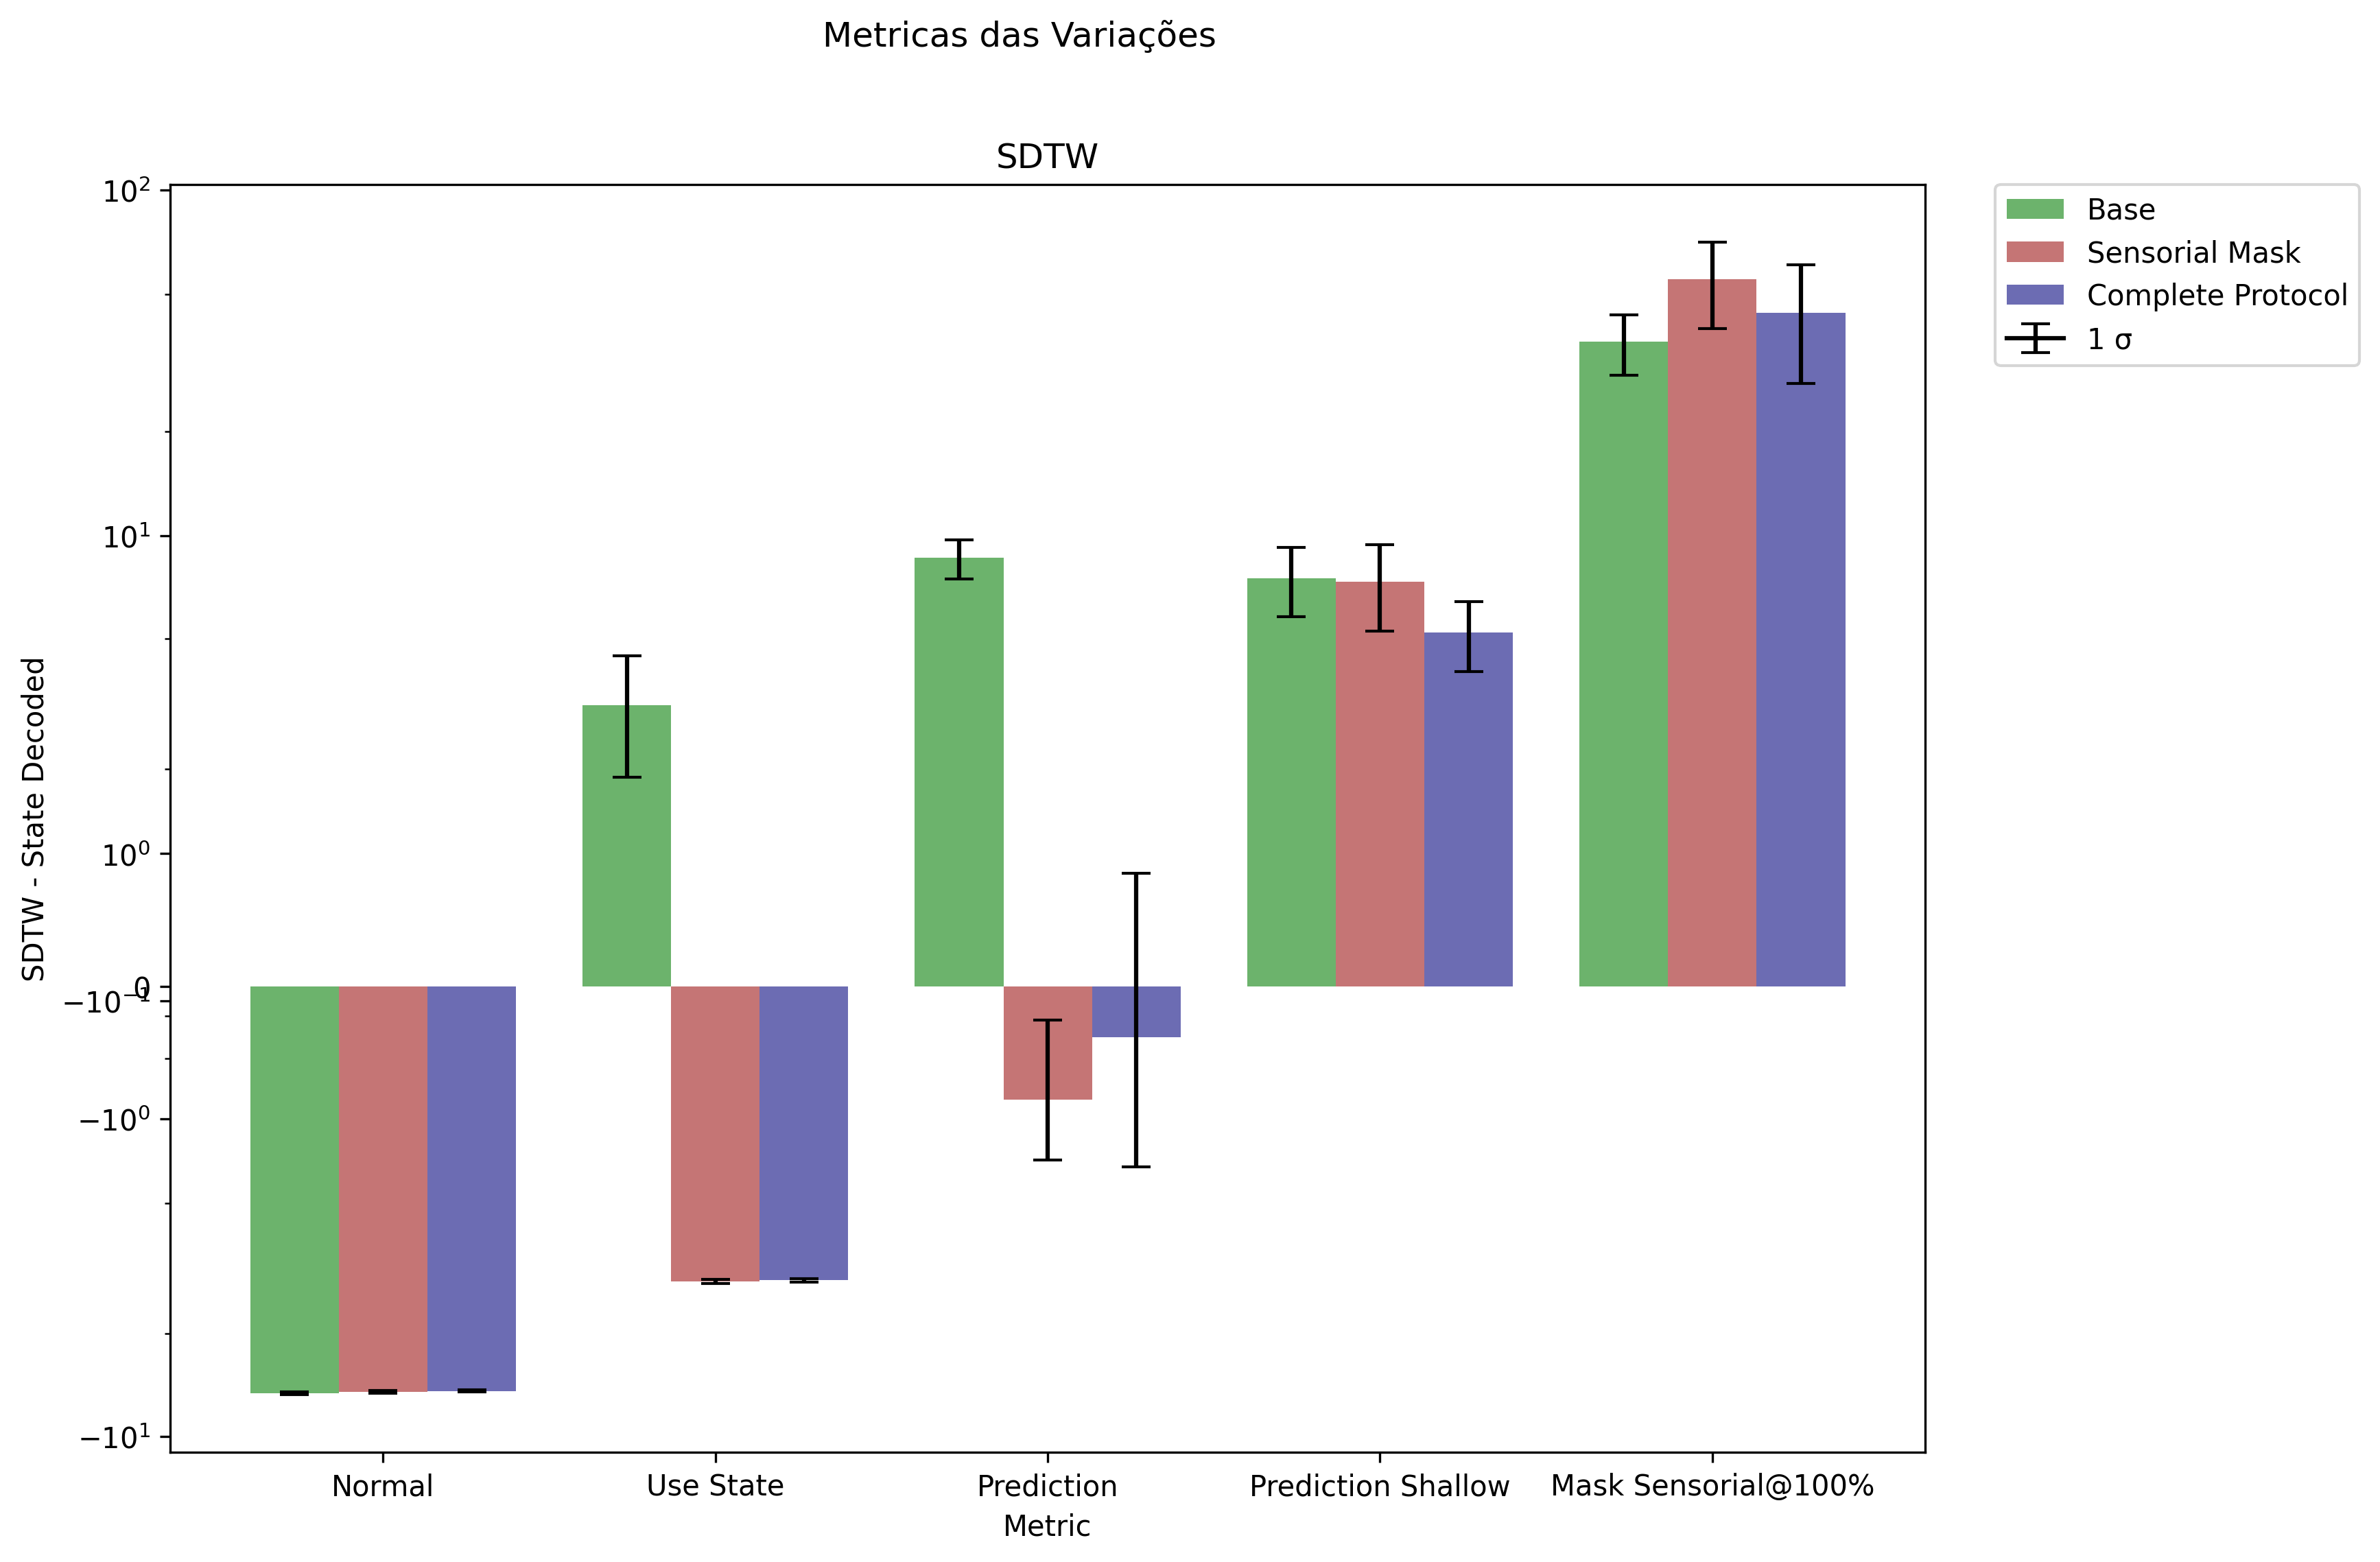

In [14]:
fig, ax = plt.subplots(dpi=300, figsize=(11, 8))

fig.suptitle("Metricas das Variações")
ax.set_title("SDTW")

metrics_bar_with_errorbar(metrics_sorted, "state_decoded_sdtw", metric_names, metric_labels, "Variations", pallete, "1 σ", ax)
ax.set_ylabel("SDTW - State Decoded")
ax.set_yscale("asinh")

ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

In [15]:
from tensordict import TensorDict
import os

In [16]:
experiment_name = "toy1d_experiment0_protocol_test"

In [ ]:
samples = {}

for variation in variations:
    samples[variation] = {}

    base_path = os.path.join(experiment_name, variation, "run_4", "metrics_logits")
    
    for name in ["normal", "use_state", "prediction", "prediction_shallow", "targets"]:
        path = os.path.join(base_path, name)
        samples[variation][name] = TensorDict.load(path)



C:\Users\eltsu\AppData\Local\Temp\ipykernel_23804\859287273.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


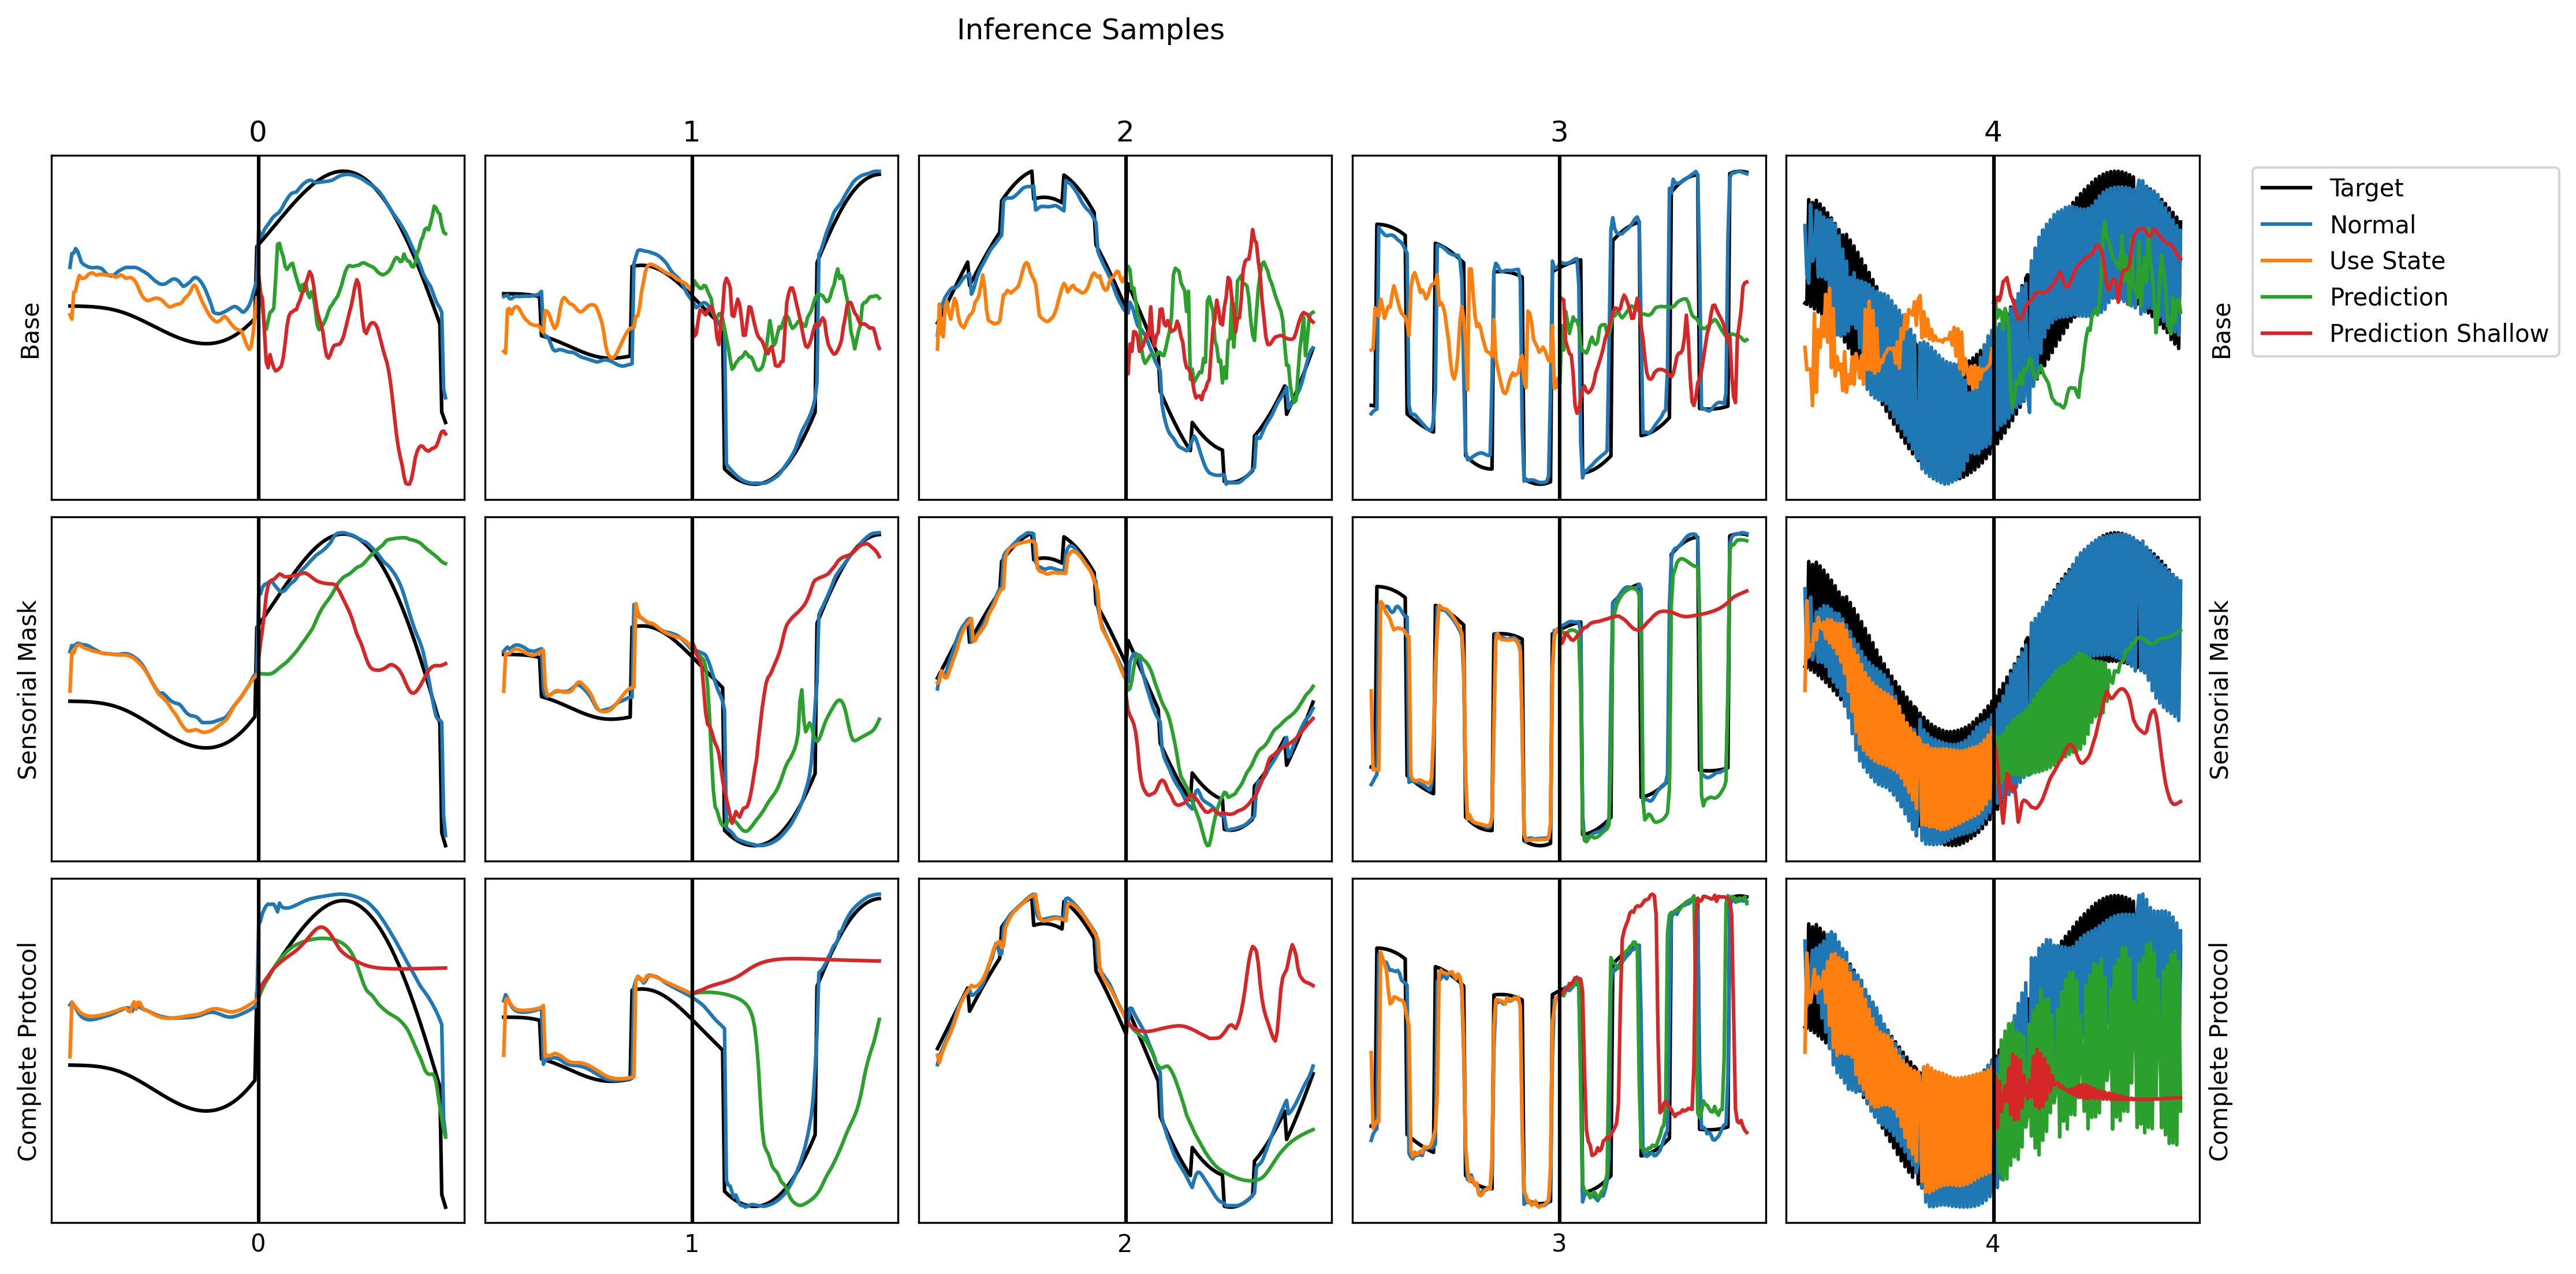

In [44]:
time = np.linspace(0, 199, 200, dtype=int)

indexes = [0, 1, 2, 9, 4, 8, 10, 11, 12]


axis = 0
fig, axs = plt.subplots(3, 5, dpi=300, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
index = 0
for j in range(3):
    for i in range(5):
        row = index // 5
        column = index % 5

        axs[row, column].plot(samples[variations[j]]["targets"]["state_decoded"][indexes[i]], label="Target", color="black")
        axs[row, column].plot(samples[variations[j]]["normal"]["state_decoded"][indexes[i]], label="Normal")

        axs[row, column].plot(time[:100], samples[variations[j]]["use_state"]["state_decoded"][indexes[i]], label="Use State")

        axs[row, column].plot(time[100:], samples[variations[j]]["prediction"]["state_decoded"][indexes[i]], label="Prediction")

        axs[row, column].plot(time[100:], samples[variations[j]]["prediction_shallow"]["state_decoded"][indexes[i]], label="Prediction Shallow")

        axs[row, column].set_xticks([])
        axs[row, column].set_yticks([])

        axs[row, column].axvline(100, color="black")

        index += 1


for i, name in enumerate(name_map.values()):
    axs[i,0].set_ylabel(name)
    axs[i,4].set_ylabel(name)

for i in range(3):
    axs[i,4].yaxis.set_label_position("right")
    axs[i,4].yaxis.tick_right()


for i in range(5):
    axs[0,i].set_title(str(i))
    axs[2,i].set_xlabel(str(i))

plt.legend(bbox_to_anchor=(1.9, 3.1), loc='upper right')

plt.suptitle("Inference Samples")
plt.tight_layout()


plt.show()
